In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from cam_class_optimization import CamGeneration
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os
import sys
import pandas as pd
import plotly.express as px

In [2]:
class multi_objective_mechanism_optimization(Problem):
    
    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self,gear_ratios,initial_gear_ratio,percentages,target_peak_force,target_percentage_max):
        
        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        xl = np.zeros(9)
        xu = np.zeros(9)
        # perc_ranges = {0:[0,0.8],1:[.08,.16],2:[0.16,.24],3:[.24,.32],4:[0.32,.4],5:[.4,.48],6:[.48,.56]
        # ,7:[.56,.64]}
        for i,row in enumerate(gear_ratios):
            for j,elem in enumerate(row):
                if i == 0:
                    xl[(i*8)+j] = 0.5
                    xu[(i*8)+j] = 5
                # else:
                #     xl[(i*8)+j] = perc_ranges[j][0]
                #     xu[(i*8)+j] = perc_ranges[j][1]
       
        xl[-1] = 0.5
        xu[-1] = 1
        print(xl,xu)
        super().__init__(n_var = (gear_ratios.shape[1]) + 1, n_obj=4, xl=xl, xu=xu, elementwise_evaluation=True)
        
        # Store mechanism information for later 
        self.gear_ratios = gear_ratios
        self.initial_gear_ratio =initial_gear_ratio
        self.target_peak_force =target_peak_force
        self.target_percentage_max =target_percentage_max
        self.percentages=percentages
        
        

        
    def _evaluate(self, x, out, *args, **kwargs):
        
        # Step 1: Reshape
        # print(x.shape[0])
        # gear_ratios = x[0][:-2]
        # initial_gr = x[-1]
        # print('this is gr',gear_ratios,initial_gr)
        # Step 2: Simulate
        results_dict = {1:np.zeros(x.shape[0]),2:np.zeros(x.shape[0]),3:np.zeros(x.shape[0]),4:np.zeros(x.shape[0])}
        for i,sub_x in enumerate(x):
            gear_ratios = sub_x[:-1]
            #gear_ratios = gear_ratios.reshape((2,-1))
            gear_ratios = np.hstack((gear_ratios,self.percentages))
            gear_ratios= gear_ratios.reshape((2,-1))
            gear_ratios[1,0] = 0
            gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
            
            # print(gear_ratios)
            initial_gr = sub_x[-1]
            filename = 'data/Knee-angle_Chugo_2006.csv'
            Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180) # create Cam object given gear ratios
            R_plus_r = Cam.calculate_cam_radii() # get maximum radius from generated cams
            forces,percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1,plot=False) # get forces from generated cams
            ideal_perc_ind = np.where(np.round(percentages,1) == 32.3)[0][0]
            ideal_perc_force = forces[ideal_perc_ind] # get magnitude of force at the stance percentage where max force is ideally timed
            max_force = max(forces)
            max_force_perc = percentages[np.where(forces == max_force)[0][0]] # get stance percentage where max force actually occurs
            sitting_perc_ind = np.where(np.round(percentages,1) == 0)[0][0]
            sitting_force = forces[sitting_perc_ind] # get actual forces at 0% stance (sitting)    

            results_dict[1][i] = R_plus_r
            results_dict[2][i] = abs(max_force_perc-self.target_percentage_max)
            results_dict[3][i] = abs(max_force-self.target_peak_force)
            results_dict[4][i] = abs(sitting_force)

        out["F"] = [results_dict[1],results_dict[2],results_dict[3],results_dict[4]]#,results_dict[3],results_dict[4]]# size, max_force_perc, max_force_diff, sitting_force
        # check to see if the mechanism is valid
        # if locking or over_under_defined:
        #     # if mechanism is invalid set the objective to infinity (Set both objectives to be this)
        #     out["F"] = [np.Inf, np.Inf]
        # else:
        #     # Step 3: Normalize
        #     x_norm = self.normalizer.get_oriented(x_sol[:,4,:])

        #     # Step 4: Rasterize
        #     out_pc = rasterized_curve_coords(x_norm,500)

        #     # Step 5: Compare
        #     cd = chamfer_distance(out_pc,self.tpc)

        #     # Send the chamfer distance and material to pymoo as objective
        #     out["F"] = [cd, solver.material(x0,self.C)]



In [3]:
gr0 = np.array([[0.18, 0.18, 6, 0.5, 1.4,  1.7,  1.5, 0.9], # is there a min and max value for these? - ratios are sensitive, convex check, 
                        [0  , 0.08, 0.28, 0.4, 0.45, 0.5, 0.60, 0.66]])
gr0[1, :] = 2 * np.pi * gr0[1, :]
#gear_percentages = np.array([0  , 0.08, 0.07, 0.4, 0.45, 0.5, 0.60, 0.66])
gear_percentages = np.array([0  , .08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.66])

initial_gear_ratio=0.5

pop_size = 50
generations = 1000

# Setup and instance of our problem
problem = multi_objective_mechanism_optimization(gear_ratios=gr0,
                                                initial_gear_ratio=initial_gear_ratio,
                                                percentages = gear_percentages,
                                                target_peak_force=175,
                                                target_percentage_max=32.5)
# Set up Algorithm
algorithm = NSGA2(
    pop_size=pop_size,
    n_offsprings=pop_size,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
termination = get_termination("n_gen", generations)
results = minimize(problem,
                   algorithm,
                   termination,
                   verbose=True,
                   save_history=True,
                   seed=3)
X = results.X # is this the optimal gear ratio input?
F = results.F # optimized outputs (the 4 objectives)



[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] [5. 5. 5. 5. 5. 5. 5. 5. 1.]

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     22 |             - |             -
     2 |      100 |     30 |  0.0359753240 |         ideal
     3 |      150 |     30 |  0.1422882106 |         ideal
     4 |      200 |     50 |  0.0454386902 |         ideal
     5 |      250 |     50 |  0.0279052459 |         ideal
     6 |      300 |     50 |  0.1451368101 |         nadir
     7 |      350 |     50 |  0.0146462258 |         ideal
     8 |      400 |     50 |  0.0199546893 |         ideal
     9 |      450 |     50 |  0.0192701773 |         ideal
    10 |      500 |     50 |  0.2438642751 |         nadir
    11 |      550 |     50 |  0.0520420318 |         nadir
    12 |      600 

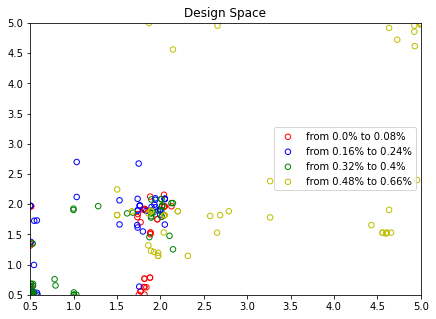

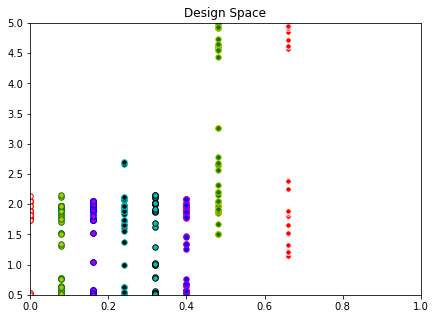

In [4]:
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.scatter(X[:, 2], X[:, 3], s=30, facecolors='none', edgecolors='b')
plt.scatter(X[:, 4], X[:, 5], s=30, facecolors='none', edgecolors='g')
plt.scatter(X[:, 6], X[:, 7], s=30, facecolors='none', edgecolors='y')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.legend([f'from {gear_percentages[0]}% to {gear_percentages[1]}%',
            f'from {gear_percentages[2]}% to {gear_percentages[3]}%',
            f'from {gear_percentages[4]}% to {gear_percentages[5]}%',
            f'from {gear_percentages[6]}% to {gear_percentages[7]}%'])
plt.title("Design Space")
plt.show()

percent_array = np.zeros_like(X[:,:8])
for i,elem in enumerate(percent_array):
    percent_array[i] = gear_percentages
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
colors = ['r','g','b','c','k','m','y','w']
for i in range(8):
    plt.scatter(percent_array[:,i], X[:, i], s=30, facecolors=colors[7-i], edgecolors=colors[i])
plt.xlim(0, 1)
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

df_dict = {'Size':F[:,0],'ideal_m_f_perc_diff':F[:,1],'ideal_max_force_diff':F[:,2],'sitting_force':F[:,3]}
df = pd.DataFrame(data=df_dict)
fig = px.scatter_3d(df, x='ideal_m_f_perc_diff', y='ideal_max_force_diff', z='sitting_force',
              color='Size')
fig.show()

There are 50 results in the pareto front!
New Gear! This is index 12!
0.274905101247136 0.40886361708527613


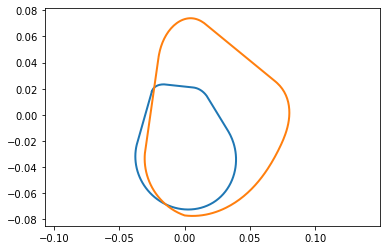

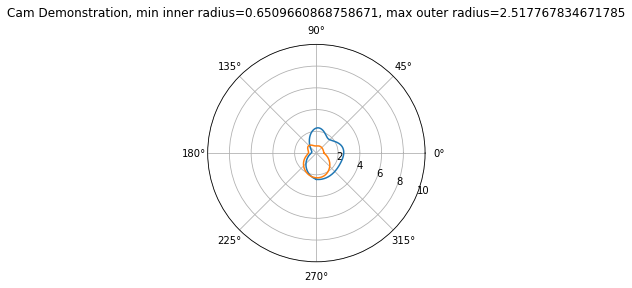

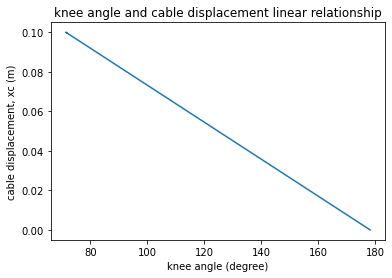

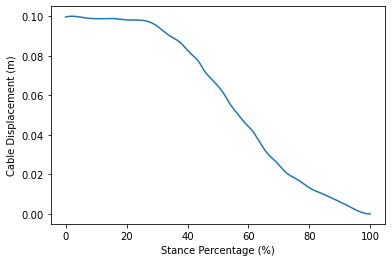

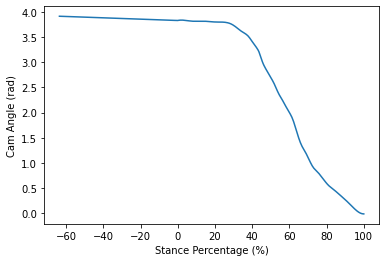

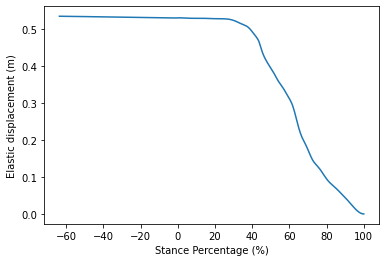

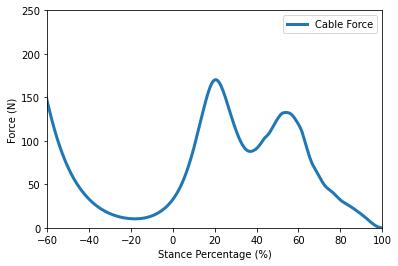

All index value of 32.3 is:  99.79314729887933
force at 32.3% =  99.79314729887933 max force of 170.31125286521163  at  20.454545454545453  %
max radii sum =  4.893121993574748
sitting force 32.653639755704084
size = 4.893121993574748, max_force_perc - 32.5 = 12.045454545454547, max_force_diff = 4.688747134788372, sitting_force = 32.653639755704084
----------------------------------END----------------------------------
New Gear! This is index 19!
0.20227675946598317 0.08040478719817598


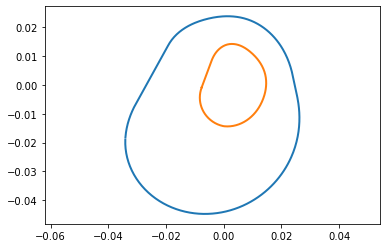

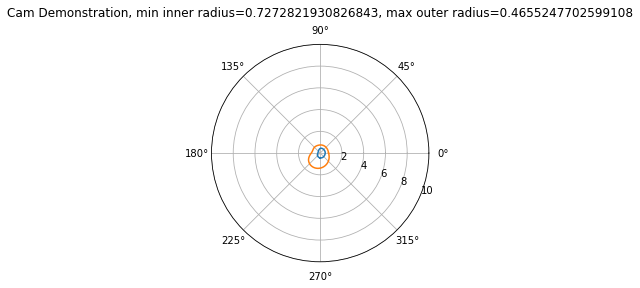

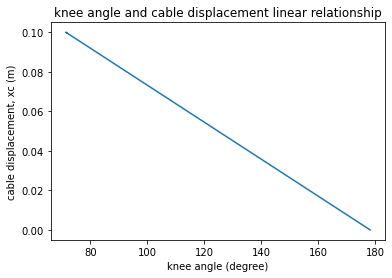

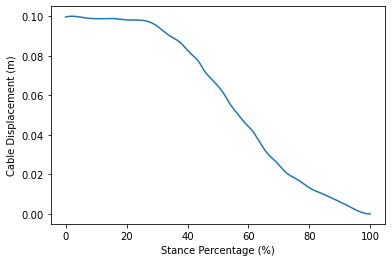

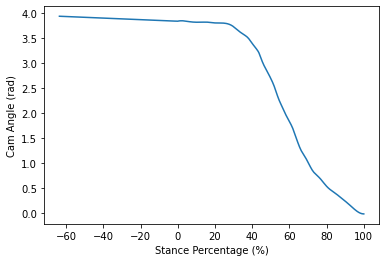

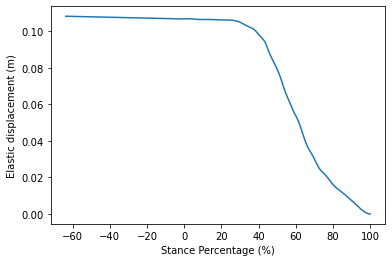

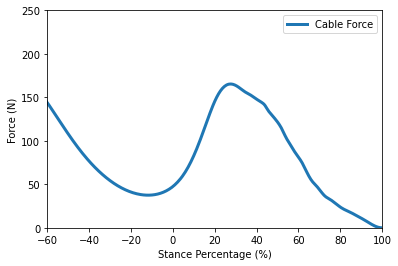

All index value of 32.3 is:  160.1505097174939
force at 32.3% =  160.1505097174939 max force of 165.33606206891318  at  27.727272727272727  %
max radii sum =  3.3211967652887218
sitting force 47.45731825477923
size = 3.3211967652887218, max_force_perc - 32.5 = 4.772727272727273, max_force_diff = 9.66393793108682, sitting_force = 47.45731825477923
----------------------------------END----------------------------------
New Gear! This is index 25!
0.28091443733754445 0.39056504181699087


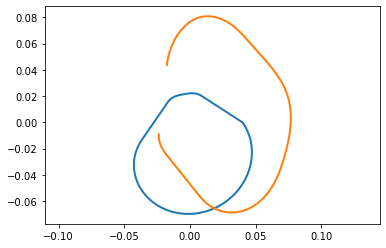

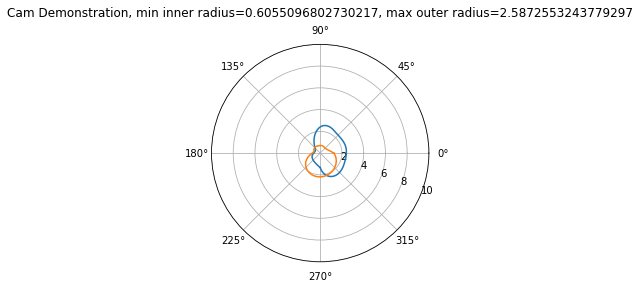

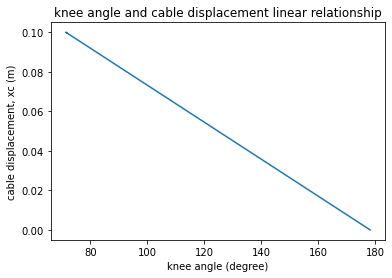

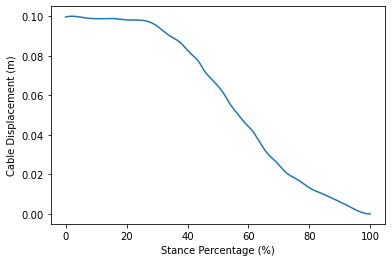

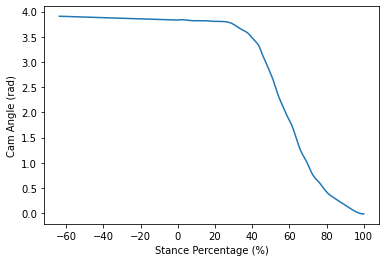

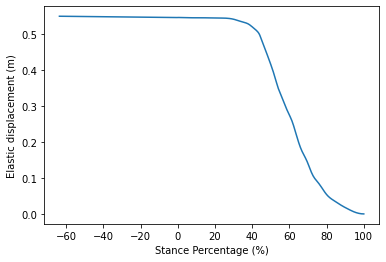

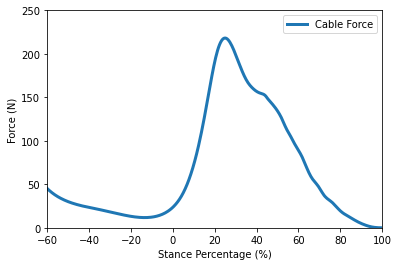

All index value of 32.3 is:  185.02324902551533
force at 32.3% =  185.02324902551533 max force of 218.1793182516637  at  25.0  %
max radii sum =  5.0491316236780825
sitting force 23.619301484289686
size = 5.0491316236780825, max_force_perc - 32.5 = 7.5, max_force_diff = 43.17931825166369, sitting_force = 23.619301484289686
----------------------------------END----------------------------------
New Gear! This is index 42!
0.26748779043589277 0.3345356683916766


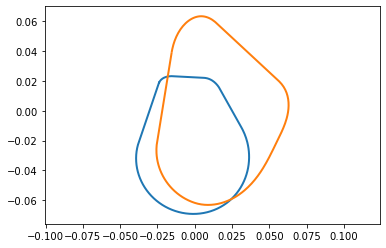

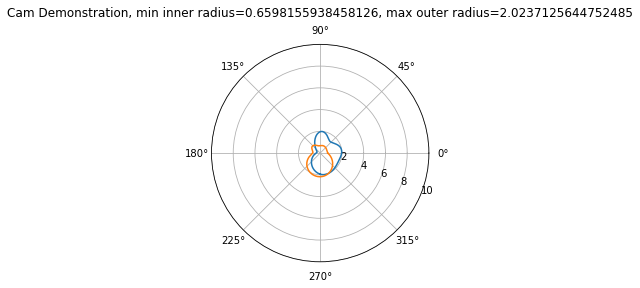

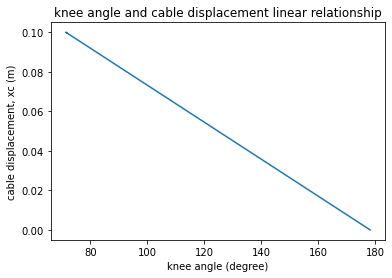

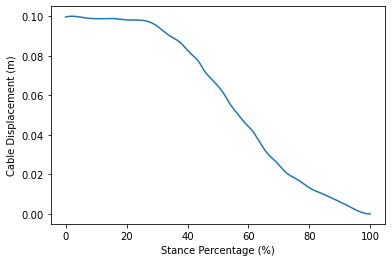

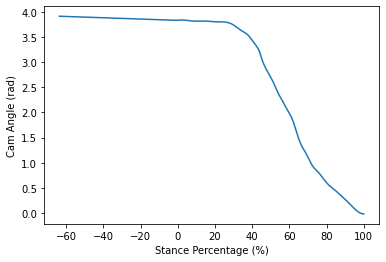

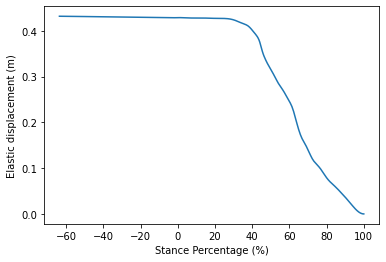

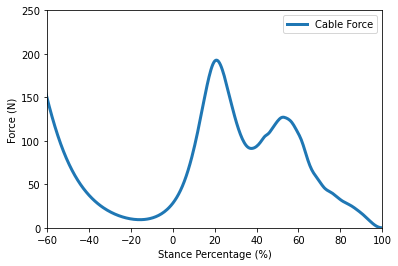

All index value of 32.3 is:  107.47295348561072
force at 32.3% =  107.47295348561072 max force of 192.76490837853686  at  20.90909090909091  %
max radii sum =  4.392022481357236
sitting force 28.349025897935913
size = 4.392022481357236, max_force_perc - 32.5 = 11.59090909090909, max_force_diff = 17.76490837853686, sitting_force = 28.349025897935913
----------------------------------END----------------------------------
New Gear! This is index 47!
0.21725675650138998 0.2284778804827945


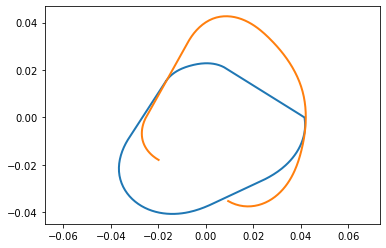

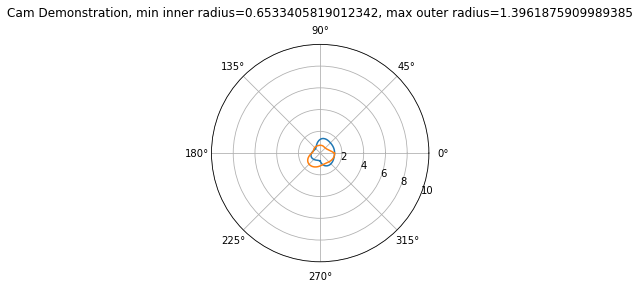

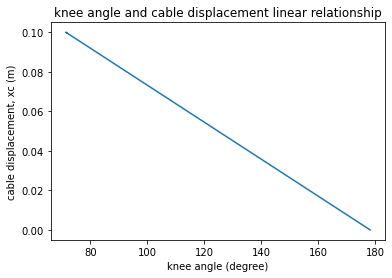

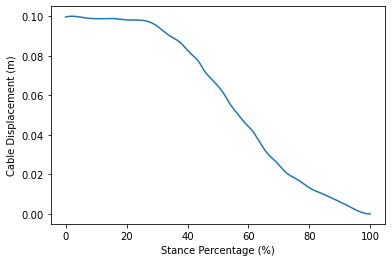

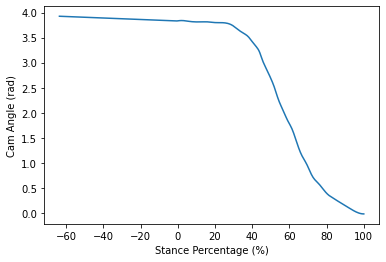

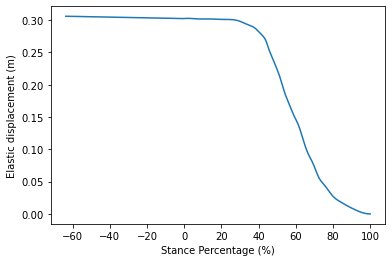

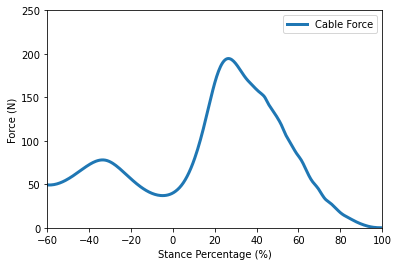

All index value of 32.3 is:  181.13838416326507
force at 32.3% =  181.13838416326507 max force of 194.58948342139232  at  26.363636363636363  %
max radii sum =  2.941775712227527
sitting force 40.02805193711081
size = 2.941775712227527, max_force_perc - 32.5 = 6.136363636363637, max_force_diff = 19.589483421392316, sitting_force = 40.02805193711081
----------------------------------END----------------------------------


In [5]:
if len(results.X) <10:
    for sub_x in results.X:
        gear_ratios = sub_x[:-1]
        initial_gr = sub_x[-1]
        gear_ratios = np.hstack((gear_ratios,gear_percentages))
        gear_ratios= gear_ratios.reshape((2,-1))
        gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
        Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180)
        R_plus_r = Cam.calculate_cam_radii()
        filename = 'data/Knee-angle_Chugo_2006.csv'
        inner_pts, outer_pts = Cam.cam_pts(stroke=0.1)
        forces,percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1,plot=True)
else:
    range_limit = 50
    print(f'There are {len(X)} results in the pareto front!')
    for i,sub_x in enumerate(X):
        in_range_flag = True
        for res in F[i]:
            if res > range_limit:
                in_range_flag = False
        if in_range_flag:
            print(f'New Gear! This is index {i}!')
            gear_ratios = sub_x[:-1]
            initial_gr = sub_x[-1]
            gear_ratios = np.hstack((gear_ratios,gear_percentages))
            gear_ratios= gear_ratios.reshape((2,-1))
            gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
            Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180)
            R_plus_r = Cam.calculate_cam_radii()
            filename = 'data/Knee-angle_Chugo_2006.csv'
            inner_pts, outer_pts = Cam.cam_pts(stroke=0.1)
            forces,percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1,plot=True)
            ideal_perc_ind = np.where(np.round(percentages,1) == 32.3)[0][0]
            ideal_perc_force = forces[ideal_perc_ind]
            max_force = max(forces)
            max_force_perc = percentages[np.where(forces == max_force)[0][0]]
            sitting_perc_ind = np.where(np.round(percentages,1) == 0)[0][0]
            sitting_force = forces[sitting_perc_ind] 

            print("All index value of 32.3 is: ", ideal_perc_force)
            print('force at 32.3% = ',ideal_perc_force, 'max force of', max_force,' at ',max_force_perc, ' %')
            print('max radii sum = ',R_plus_r)
            print(f'sitting force {sitting_force}')
            print(f'size = {F[i][0]}, max_force_perc - 32.5 = {F[i][1]}, max_force_diff = {F[i][2]}, sitting_force = {F[i][3]}')
            print('----------------------------------END----------------------------------')

In [ ]:

df_dict = {'Size':F[:,0],'ideal_m_f_perc_diff':F[:,1],'ideal_max_force_diff':F[:,2],'sitting_force':F[:,3]}
df = pd.DataFrame(data=df_dict)
fig = px.scatter_3d(df, x='ideal_m_f_perc_diff', y='ideal_max_force_diff', z='sitting_force',
              color='Size')
fig.show()

# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(projection='3d')
# p = ax.scatter(F[:,1], F[:,2], F[:,3],c=F[:,0])
# fig.colorbar(p)
